## 1001 Genome ML Classifier

The pipeline attempts to select the genes associated with different phenotypes based on the varying transcriptomes of different accessions via Pseudobulking. 

Some associated results from this pipeline and linear modelling can be found here: https://docs.google.com/presentation/d/1PbmYhv_nslxEZFPF7JLtSIL2ANF63-WbFdWRNgYipP4/edit?usp=sharing

Pipeline also includes:
- calculating % of cell specific genes in each cluster (can print out lists of the cell specific genes and further analyse in virtual plant)

Thoughts on overall progress of workflow:
Right now we are using XGBoost for feature selection, howere there is also potential to use LASSO and maybe other models to further refine the workflow.
When uploaded to virtual plant we see the following results:


We hope to see more of an overlap between Linear Modelling genes and more quantity in ML classifier pipeline after working on the LMM normalisationg and getting more data. The pipeline has shown good progress because of higher % in cell type specific genes, which people would be more interested in. We have tried logit regression but it didn't make sense because we converted the gene count into binary numbers rather than output, and Arthur recommended against it.


In [22]:
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns

Importing accession-specific phenotype metadata from https://arapheno.1001genomes.org/phenotypes/ 

In [8]:
FloweringTime_phenotype = pd.read_csv("../../EckerLab/Phenotypes/FloweringTimePhenotype.csv")

In [239]:
FloweringTime_phenotype

,phenotype_name,accession_id,accession_name,accession_cs_number,accession_longitude,accession_latitude,accession_country,phenotype_value,obs_unit_id,cluster_outcome
0,FT16,10000,Tuescha-9,NaN,9.0500,48.5300,GER,54.500000,6520,0.0
1,FT16,100000,Wil-1,CS78702,25.3167,54.6833,Lithuania,48.250000,6521,0.0
2,FT16,10001,TueV-13,CS76407,9.0500,48.5200,GER,49.500000,6522,0.0
3,FT16,10002,TueWal-2,CS76405,9.0400,48.5300,GER,42.500000,6523,0.0
4,FT16,10003,WalHaesB4,NaN,9.1900,48.6000,GER,57.666667,6524,0.0
...,...,...,...,...,...,...,...,...,...,...
1117,FT16,9994,Ey15-2,NaN,8.7700,48.4300,GER,54.500000,7677,0.0
1118,FT16,9995,HKT2.4,CS76404,9.4000,48.1400,GER,41.750000,7678,0.0
1119,FT16,9996,Nie1-2,CS76402,8.8000,48.5200,GER,38.250000,7679,0.0
1120,FT16,9997,Rue3.1-31,CS76406,9.1600,48.5600,GER,51.500000,7680,0.0


calculating median of phenotype value to set binary threshold (anything >= median will be classified as 1, values below median = 0)

In [16]:
median = np.median(FloweringTime_phenotype['phenotype_value'])

In [13]:
FloweringTime_phenotype['phenotype_value'].shape[0]


1123

In [19]:
outcome = np.zeros((FloweringTime_phenotype['phenotype_value'].shape[0],1))
outcome[np.where(FloweringTime_phenotype['phenotype_value'] >= median)] = 1
FloweringTime_phenotype['cluster_outcome'] = outcome

,phenotype_name,accession_id,accession_name,accession_cs_number,accession_longitude,accession_latitude,accession_country,phenotype_value,obs_unit_id,cluster_outcome
0,FT16,10000,Tuescha-9,NaN,9.0500,48.5300,GER,54.500000,6520,0.0
1,FT16,100000,Wil-1,CS78702,25.3167,54.6833,Lithuania,48.250000,6521,0.0
2,FT16,10001,TueV-13,CS76407,9.0500,48.5200,GER,49.500000,6522,0.0
3,FT16,10002,TueWal-2,CS76405,9.0400,48.5300,GER,42.500000,6523,0.0
4,FT16,10003,WalHaesB4,NaN,9.1900,48.6000,GER,57.666667,6524,0.0
...,...,...,...,...,...,...,...,...,...,...
1118,FT16,9995,HKT2.4,CS76404,9.4000,48.1400,GER,41.750000,7678,0.0
1119,FT16,9996,Nie1-2,CS76402,8.8000,48.5200,GER,38.250000,7679,0.0
1120,FT16,9997,Rue3.1-31,CS76406,9.1600,48.5600,GER,51.500000,7680,0.0
1121,FT16,9998,Star-8,CS76400,8.8200,48.4300,GER,46.250000,7681,0.0


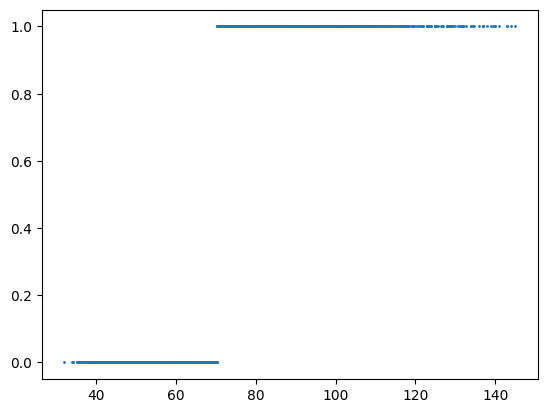

In [26]:
plt.scatter(FloweringTime_phenotype['phenotype_value'], FloweringTime_phenotype['cluster_outcome'], s=1)

In [142]:
sample_cluster = pd.read_csv("../../EckerLab/1001_genome/ML_cluster.csv", index_col = 0)
sample_cluster

,0088,0108,0159,0350,0351,0403,0410,0424,0428,0430,...,9952,9955,9958,9960,9965,997_,9972,9983,9985,9990
AT1G01010,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AT1G01020,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
AT1G01030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01040,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,1,1,1,0,0
AT1G01050,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G47280,1,0,1,1,0,0,1,0,0,0,...,1,1,1,1,0,0,1,1,1,1
AT3G23120,1,0,1,1,0,0,1,0,0,0,...,1,0,1,1,0,1,1,1,1,1
AT1G24370,1,0,1,1,0,0,1,0,1,0,...,1,0,1,1,0,0,1,1,1,1
AT4G16215,1,0,1,1,0,0,1,0,0,0,...,1,0,1,1,0,0,1,1,1,1


In [143]:
sample_cluster.columns = np.array([s.replace('_', '') for s in sample_cluster.columns]).astype(int)

In [138]:
FloweringTime_phenotype = FloweringTime_phenotype.iloc[np.where(FloweringTime_phenotype['accession_id'].unique())]

In [144]:
intersect_accessions = np.intersect1d(FloweringTime_phenotype['accession_id'],sample_cluster.columns)

In [147]:
sample_cluster_mod = sample_cluster[intersect_accessions].T

In [148]:
sample_cluster_mod

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,AT4G13620,AT4G27140,AT4G30000,AT4G37530,AT5G29075,AT5G47280,AT3G23120,AT1G24370,AT4G16215,AT5G37110
88,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
108,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
159,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
350,1,1,0,1,0,0,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
351,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9972,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
9983,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9985,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [168]:
FloweringTime_phenotype_mod = FloweringTime_phenotype_mod.iloc[np.where(FloweringTime_phenotype_mod['accession_id'].unique())]

In [169]:
X_train = sample_cluster_mod
y_train =FloweringTime_phenotype_mod['cluster_outcome']

In [170]:
X_train

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,AT4G13620,AT4G27140,AT4G30000,AT4G37530,AT5G29075,AT5G47280,AT3G23120,AT1G24370,AT4G16215,AT5G37110
88,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
108,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
159,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
350,1,1,0,1,0,0,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
351,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9972,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
9983,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9985,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [171]:
y_train

540     0.0
33      0.0
46      0.0
60      0.0
61      0.0
       ... 
1082    0.0
1087    0.0
1095    0.0
1106    0.0
1108    0.0
Name: cluster_outcome, Length: 526, dtype: float64

In [172]:
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_train, y_train)   

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [201]:
X_train

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,AT4G13620,AT4G27140,AT4G30000,AT4G37530,AT5G29075,AT5G47280,AT3G23120,AT1G24370,AT4G16215,AT5G37110
88,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
108,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
159,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
350,1,1,0,1,0,0,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
351,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9972,0,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
9983,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9985,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [265]:
feature_selected = X_train.iloc[:,np.reshape(np.where(model.feature_importances_>0),(1,np.where(model.feature_importances_>0)[0].shape[0]))[0]]

In [266]:
feature_selected

,AT1G01090,AT1G01540,AT1G02305,AT1G02560,AT1G02910,AT1G03530,AT1G03900,AT1G04250,AT1G04350,AT1G04420,...,AT5G59880,AT5G60550,AT5G60820,AT5G60860,AT5G61480,AT5G63850,AT5G63950,AT5G65207,AT5G65270,AT5G65390
88,1,1,1,1,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
108,1,0,1,1,1,1,0,1,1,1,...,1,0,1,1,1,1,0,0,1,1
159,1,0,1,0,1,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
350,1,0,0,1,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
351,1,0,1,1,1,1,1,1,1,1,...,0,1,0,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,1,0,1,1,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
9972,1,0,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9983,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9985,0,0,1,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [267]:
feature_selected.columns


Index(['AT1G01090', 'AT1G01540', 'AT1G02305', 'AT1G02560', 'AT1G02910',
       'AT1G03530', 'AT1G03900', 'AT1G04250', 'AT1G04350', 'AT1G04420',
       ...
       'AT5G59880', 'AT5G60550', 'AT5G60820', 'AT5G60860', 'AT5G61480',
       'AT5G63850', 'AT5G63950', 'AT5G65207', 'AT5G65270', 'AT5G65390'],
      dtype='object', length=635)

In [234]:
np.savetxt('/Users/tanvijain/Documents/EckerLab/ml_genes_ftp.txt', feature_selected.columns, delimiter='\n', fmt='%s') 

In [ ]:
content = str(feature_selected.columns)
file.write(content)
file.close()
 
# Displaying the contents of the text file
file = open("ml_genes_ftp.txt", "r")
content = file.read()
 
print("\nContent in file1.txt:\n", content)
file.close()

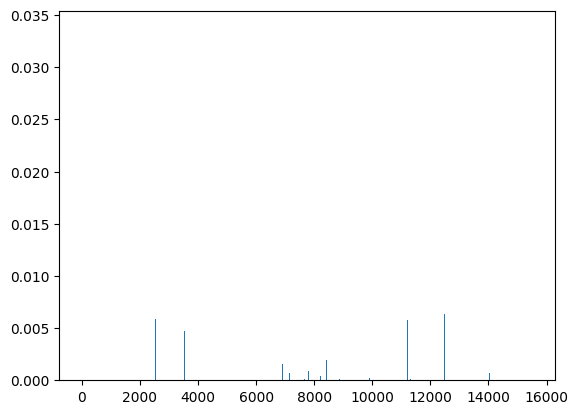

In [175]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [ ]:
FloweringTime_phenotype = pd.read_csv("../../EckerLab/Phenotypes/FloweringTimePhenotype.csv")
median = np.median(FloweringTime_phenotype['phenotype_value'])
FloweringTime_phenotype['phenotype_value'].shape[0]
outcome = np.zeros((FloweringTime_phenotype['phenotype_value'].shape[0],1))
outcome[np.where(FloweringTime_phenotype['phenotype_value'] >= median)] = 1
FloweringTime_phenotype['cluster_outcome'] = outcome
plt.scatter(FloweringTime_phenotype['phenotype_value'], FloweringTime_phenotype['cluster_outcome'], s=1)


In [272]:
sample_cluster = pd.read_csv("../../EckerLab/1001_genome/ML_cluster.csv", index_col = 0)
sample_cluster.columns = np.array([s.replace('_', '') for s in sample_cluster.columns]).astype(int)
FloweringTime_phenotype = FloweringTime_phenotype.iloc[np.where(FloweringTime_phenotype['accession_id'].unique())]
intersect_accessions = np.intersect1d(FloweringTime_phenotype['accession_id'],sample_cluster.columns)
sample_cluster_mod = sample_cluster[intersect_accessions].T
FloweringTime_phenotype_mod = FloweringTime_phenotype.iloc[np.where(FloweringTime_phenotype['accession_id'].isin(intersect_accessions))].sort_values(by=['accession_id'])
FloweringTime_phenotype_mod = FloweringTime_phenotype_mod.iloc[np.where(FloweringTime_phenotype_mod['accession_id'].unique())]

X_train = sample_cluster_mod
y_train =FloweringTime_phenotype_mod['cluster_outcome']
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_train, y_train)   
feature_selected = X_train.iloc[:,np.reshape(np.where(model.feature_importances_>0),(1,np.where(model.feature_importances_>0)[0].shape[0]))[0]]
feature_selected.columns


Index(['AT1G01090', 'AT1G01540', 'AT1G02305', 'AT1G02560', 'AT1G02910',
       'AT1G03530', 'AT1G03900', 'AT1G04250', 'AT1G04350', 'AT1G04420',
       ...
       'AT5G59880', 'AT5G60550', 'AT5G60820', 'AT5G60860', 'AT5G61480',
       'AT5G63850', 'AT5G63950', 'AT5G65207', 'AT5G65270', 'AT5G65390'],
      dtype='object', length=635)

In [275]:
np.where(model.feature_importances_!=0)

(array([    8,    38,    95,   108,   129,   171,   194,   226,   235,
          241,   263,   265,   292,   294,   313,   364,   385,   389,
          408,   435,   461,   519,   572,   602,   639,   645,   672,
          682,   705,   709,   758,   787,   804,   811,   826,   843,
          866,   872,   961,   974,  1014,  1028,  1030,  1045,  1086,
         1101,  1137,  1186,  1207,  1233,  1246,  1301,  1327,  1380,
         1397,  1400,  1403,  1409,  1412,  1481,  1524,  1543,  1570,
         1583,  1594,  1613,  1636,  1644,  1647,  1668,  1670,  1683,
         1697,  1723,  1728,  1743,  1758,  1769,  1781,  1794,  1797,
         1812,  1826,  1827,  1860,  1866,  1892,  1909,  1924,  1925,
         1943,  1954,  1970,  2006,  2015,  2050,  2062,  2074,  2076,
         2084,  2096,  2112,  2133,  2171,  2199,  2231,  2243,  2296,
         2307,  2337,  2354,  2395,  2401,  2404,  2426,  2432,  2448,
         2506,  2525,  2538,  2564,  2586,  2594,  2622,  2642,  2682,
      

In [282]:
#df['genes'] = feature_selected.columns
#df['importance_score'] = model.feature_importances_[model.feature_importances_>0]

df

,genes,importance_score
0,AT1G01090,0.000087
1,AT1G01540,0.000462
2,AT1G02305,0.001017
3,AT1G02560,0.000116
4,AT1G02910,0.000909
...,...,...
630,AT5G63850,0.002687
631,AT5G63950,0.000089
632,AT5G65207,0.000568
633,AT5G65270,0.000258


Actual Workflow for all cluster starts here

In [284]:
import os

In [285]:
#training all pseudobulk clusters to calculate importance score of each gene using xgb
directory = "../../EckerLab/1001_genome/Pseudobulk_cluster_dfs"
selected_features_dict = {}
for cluster in os.listdir(directory):
    sample_cluster = pd.read_csv(os.path.join(directory, cluster), index_col = 0)
    sample_cluster.columns = np.array([s.replace('_', '') for s in sample_cluster.columns]).astype(int)
    FloweringTime_phenotype = FloweringTime_phenotype.iloc[np.where(FloweringTime_phenotype['accession_id'].unique())]
    intersect_accessions = np.intersect1d(FloweringTime_phenotype['accession_id'],sample_cluster.columns)
    sample_cluster_mod = sample_cluster[intersect_accessions].T
    FloweringTime_phenotype_mod = FloweringTime_phenotype.iloc[np.where(FloweringTime_phenotype['accession_id'].isin(intersect_accessions))].sort_values(by=['accession_id'])
    FloweringTime_phenotype_mod = FloweringTime_phenotype_mod.iloc[np.where(FloweringTime_phenotype_mod['accession_id'].unique())]
    X_train = sample_cluster_mod
    y_train =FloweringTime_phenotype_mod['cluster_outcome']
    model = xgb.XGBClassifier(objective="binary:logistic")
    model.fit(X_train, y_train)   
    feature_selected = X_train.iloc[:,np.reshape(np.where(model.feature_importances_>0),(1,np.where(model.feature_importances_>0)[0].shape[0]))[0]]
    df = pd.DataFrame(np.column_stack((feature_selected.columns,model.feature_importances_[model.feature_importances_>0])), columns=['genes','importance_score'])
    selected_features_dict[cluster] = df

In [288]:
import seaborn as sns

In [465]:
#create heatmap matrix
union_genes = np.array([])
for cluster in selected_features_dict:
    df = selected_features_dict[cluster]
    union_genes = np.union1d(df['genes'], union_genes)
    consolidated_matrix = pd.DataFrame(union_genes, columns = ['genes'])
for i, cluster in enumerate(selected_features_dict.keys()):
    consolidated_matrix[cluster] = np.zeros((consolidated_matrix.shape[0],1))
    for i in range(len(consolidated_matrix['genes'])):
        gene = consolidated_matrix['genes'][i]
        idx = np.where(selected_features_dict[cluster]['genes'] == gene)[0]
        if len(idx)!=0:
            importance_score = selected_features_dict[cluster].loc[idx]["importance_score"]
            consolidated_matrix.loc[i,[cluster]] = float(importance_score)

consolidated_matrix = consolidated_matrix.set_index('genes')
    

          genes  6.csv     7.csv     5.csv     4.csv  1.csv     3.csv  \
0     AT1G01010    0.0  0.000000  0.000000  0.000000    0.0  0.000000   
1     AT1G01020    0.0  0.000000  0.000000  0.001733    0.0  0.001350   
2     AT1G01040    0.0  0.000000  0.000947  0.000000    0.0  0.000000   
3     AT1G01050    0.0  0.000000  0.000000  0.000000    0.0  0.000449   
4     AT1G01090    0.0  0.001687  0.000126  0.001525    0.0  0.000000   
...         ...    ...       ...       ...       ...    ...       ...   
4180  AT5G67460    0.0  0.000000  0.000000  0.004958    0.0  0.000000   
4181  AT5G67530    0.0  0.000000  0.000000  0.000000    0.0  0.003740   
4182  AT5G67540    0.0  0.000000  0.000000  0.000000    0.0  0.000000   
4183  AT5G67560    0.0  0.000000  0.000000  0.000000    0.0  0.000000   
4184  AT5G67570    0.0  0.000000  0.000000  0.000000    0.0  0.000000   

         2.csv  19.csv  18.csv    16.csv    17.csv    15.csv  14.csv   10.csv  \
0     0.000000     0.0     0.0  0.000000  

In [493]:
consolidated_matrix

,6.csv,7.csv,5.csv,4.csv,1.csv,3.csv,2.csv,19.csv,18.csv,16.csv,17.csv,15.csv,14.csv,10.csv,11.csv,13.csv,12.csv,9.csv,8.csv
genes,,,,,,,,,,,,,,,,,,,
AT1G01010,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.008934,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
AT1G01020,0.0,0.000000,0.000000,0.001733,0.0,0.001350,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
AT1G01040,0.0,0.000000,0.000947,0.000000,0.0,0.000000,0.001258,0.0,0.0,0.000133,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.001522
AT1G01050,0.0,0.000000,0.000000,0.000000,0.0,0.000449,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
AT1G01090,0.0,0.001687,0.000126,0.001525,0.0,0.000000,0.000217,0.0,0.0,0.000000,0.005803,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G67460,0.0,0.000000,0.000000,0.004958,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
AT5G67530,0.0,0.000000,0.000000,0.000000,0.0,0.003740,0.000000,0.0,0.0,0.000000,0.001064,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000
AT5G67540,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00224,0.000000,0.0,0.0,0.0,0.000000


In [501]:
np.savetxt('/Users/tanvijain/Documents/EckerLab/ml_genes_ftp.txt', consolidated_matrix.index, delimiter='\n', fmt='%s') 

<Axes: ylabel='genes'>

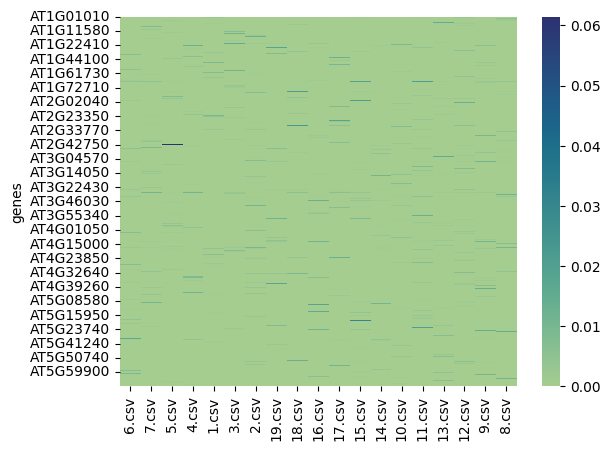

In [499]:
#visualising using heatmap
sns.heatmap(consolidated_matrix, cmap="crest")

In [525]:
markers = pd.read_csv("/Users/tanvijain/Documents/EckerLab/FindAllMarkersSorted.csv")
markers = markers.drop(markers.columns[[0,-1]],axis=1)
markers.set_index('X')
melt_markers = pd.melt(markers.iloc[:,[0,-1]],id_vars="cluster")

,cluster,variable,value
0,0,X,AT4G38770
1,0,X,AT5G25610
2,0,X,AT3G01420
3,0,X,AT1G09310
4,0,X,AT4G00360
...,...,...,...
9089,0,X,AT3G10670
9122,0,X,AT1G32160
9214,0,X,AT4G37510
9256,0,X,AT5G19860


In [530]:
i = 1
consolidated_matrix[consolidated_matrix.iloc[:,i]!=0].index


Index(['AT1G01090', 'AT1G01300', 'AT1G01320', 'AT1G02130', 'AT1G03870',
       'AT1G03930', 'AT1G04780', 'AT1G05850', 'AT1G08190', 'AT1G08450',
       ...
       'AT5G62920', 'AT5G62940', 'AT5G63700', 'AT5G63770', 'AT5G64220',
       'AT5G64260', 'AT5G64350', 'AT5G65700', 'AT5G66190', 'AT5G67100'],
      dtype='object', name='genes', length=498)

In [560]:
cell_specific_df = pd.DataFrame(columns=['clusters','significant_genes_per_cluster', 'cell_specific_genes', 'cell_specific_%'])
cell_specific_df.loc[i,'clusters'] = 1
cell_specific_df

,clusters,significant_genes_per_cluster,cell_specific_genes,cell_specific_%
0,1,NaN,NaN,NaN


In [565]:
#calculate cell type specific genes% for each cluster
markers.iloc[:,[0,-1]]
cell_specific_df = pd.DataFrame(columns=['clusters','significant_genes_per_cluster', 'cell_specific_genes', 'cell_specific_%'])
for i in range(19):
    cell_specific_i = melt_markers[melt_markers['cluster']==i]['value']
    corr_gene_i = consolidated_matrix[consolidated_matrix.iloc[:,i]!=0].index
    cell_specific_df.loc[i,'clusters'] = i
    cell_specific_df.loc[i,'significant_genes_per_cluster'] = len(np.intersect1d(cell_specific_i,corr_gene_i))
    cell_specific_df.loc[i,'cell_specific_genes'] = len(cell_specific_i)
    cell_specific_df.loc[i,'cell_specific_%'] = cell_specific_df.loc[i,'significant_genes_per_cluster']/cell_specific_df.loc[i,'cell_specific_genes'] * 100

cell_specific_df

,clusters,significant_genes_per_cluster,cell_specific_genes,cell_specific_%
0,0,80,598,13.377926
1,1,64,677,9.453471
2,2,92,774,11.886305
3,3,142,817,17.380661
4,4,96,1923,4.9922
5,5,33,452,7.300885
6,6,39,511,7.632094
7,7,14,496,2.822581
8,8,8,478,1.67364
9,9,60,951,6.309148


In [236]:
from sklearn.linear_model import Lasso

In [238]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

Lasso()